## [SoundCTM: Unifying Score-based and Consistency Models for Full-band Text-to-Sound Generation](https://openreview.net/forum?id=KrK6zXbjfO)

<a href="https://openreview.net/forum?id=KrK6zXbjfO">Openreview</a> | <a href="https://huggingface.co/spaces/hkchengrex/MMAudio">GitHub</a> | <a href="https://huggingface.co/koichisaito/soundctm_dit/tree/main">Checkpoints</a> |

[Koichi Saito](https://scholar.google.com/citations?user=UT-g5BAAAAAJ), [Dongjun Kim](https://sites.google.com/view/dongjun-kim), [Takashi Shibuya](https://scholar.google.com/citations?user=XCRO260AAAAJ), [Chieh-Hsin Lai](https://chiehhsinjesselai.github.io/), [Zhi Zhong](https://scholar.google.com/citations?user=iRVT3A8AAAAJ), [Yuhta Takida](https://scholar.google.co.jp/citations?user=ahqdEYUAAAAJ), [Yuki Mitsufuji](https://www.yukimitsufuji.com/)

Sony AI, Stanford University, and Sony Group Corporation

## Make sure we are using GPU

If not, Runtime -> Change runtime type -> T4

In [1]:
!nvidia-smi

import torch
if torch.cuda.is_available():
  print('Using GPU')
  device = 'cuda'
else:
  print('CUDA not available. Please connect to a GPU instance if possible.')
  device = 'cpu'

Sun Mar 30 19:41:44 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.5     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:01:00.0 Off |                    0 |
| N/A   45C    P0              50W / 300W |     22MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Install dependencies

In [ ]:
!pip install torch torchvision torchaudio
!git clone https://github.com/koichi-saito-sony/soundctm_dit_iclr.git
%cd /content/soundctm_dit_iclr
!pip install -e .

/home/koichi/workspaces/soundctm-Github_posting
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///home/koichi/workspaces/soundctm-Github_posting
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/kkoutini/passt_hear21 to /tmp/pip-install-uf1a9dio/hear21passt_62fd79aedbff4da0925ec33ff59c09a6
  Running command git clone --filter=blob:none --quiet https://github.com/kkoutini/passt_hear21 /tmp/pip-install-uf1a9dio/hear21passt_62fd79aedbff4da0925ec33ff59c09a6
  Resolved https://github.com/kkoutini/passt_hear21 to commit 5f1cce6a54b88faf0abad82ed428355e7931213a
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You mig

## Import libraries

In [1]:
import torchaudio
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from notebook_utils import parse_args, init_model, run_inference, save_waveforms
from pathlib import Path
from datetime import datetime

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-30 19:51:30.939422: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-30 19:51:30.973709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-30 19:51:32.087626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.war

No module named 'flash_attn'
flash_attn not installed, disabling Flash Attention


/home/koichi/workspaces/soundctm_dit_iclr/sa_edm/stable_audio_tools/models/transformer.py:126: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/koichi/workspaces/soundctm_dit_iclr/sa_edm/stable_audio_tools/models/transformer.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


## Load pretrained models (models will be downloaded automatically)
We'll load pretrained SoundCTM-DiT. 
Checkpoints will be downloaded automatically under `ckpt/models` and `ckpt/utils` 


In [ ]:
variants = "ac_v2" # 'ac_v1_iclr', 'ac_v2' 
custom_args = parse_args([
    "--variants", variants,
])
model_refs = init_model(custom_args)


GPU is available. Using GPU...
Using base URL: https://huggingface.co/koichisaito/soundctm_dit/resolve/main/
File already exists: ckpt/models/ac_v2_ema_0999_030000.pt
File already exists: ckpt/models/ac_v2_progress_state.pth
File already exists: ckpt/models/ac_v2_summary.jsonl
File already exists: ckpt/models/z_stats.pth
File already exists: ckpt/utils/630k-audioset-best.pt
File already exists: ckpt/utils/gaussiandac/weights.pth
------------------------------------------------------------------
Initialization config: {'variants': 'ac_v2', 'config': 'configs/hyperparameter_config/inference/dit_demo.yaml', 'prompt': 'bird charping near the ocean', 'cfg': 5.0, 'num_steps': 4, 'nu': 1.0, 'output_dir': PosixPath('output'), 'seed': 5031, 'sampler': 'deterministic', 'sampling_gamma': 0.0, 'test_file': 'data/test.csv', 'num_samples': 3, 'training_args': 'ckpt/models/ac_v2_summary.jsonl', 'model_ckpt_path': 'ckpt/models/', 'util_ckpt_path': 'ckpt/utils/', 'diffusion_model_type': 'dit', 'clap_te

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load the specified checkpoint ckpt/utils/630k-audioset-best.pt from users.
Load Checkpoint...


/home/koichi/workspaces/soundctm_dit_iclr/sa_edm/clap_modified/clap_module_modified/factory.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chec

Removing weight norm...
------------------------------------------------------------------
Model & VAE loaded successfully.
------------------------------------------------------------------


/home/koichi/workspaces/soundctm_dit_iclr/notebook_utils.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  progress_state = torch.load(args.load_mean_std_state_path, map

## Run the model


In [ ]:
prompt = "footsteps on snow"
seed = 43
num_steps = 16 # number of sampling steps
cfg = 5.0 # CFG scale
nu = 5.0 # CFG scale for multistep \gamma sampling
sampler = "deterministic" # "deterministic" (\sammpling_gamma = 0.0), "gamma_multistep" (1.0 >\sammpling_gamma > 0.0), "cm_multistep" (\sammpling_gamma = 1.0)
sammpling_gamma = 0.0
num_samples = 4 # number of samples to generate
output_dir = "output"

waveforms = run_inference(
    model_refs=model_refs,
    prompt=prompt,
    num_samples=num_samples,
    sampler=sampler,
    num_steps=num_steps,
    cfg=cfg,
    nu=nu,
    sampling_gamma=sammpling_gamma,
    seed=seed
)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
outdir = Path(output_dir)
output_subdir = f"variants_{variants}_seed_{seed}_steps_{num_steps}_cfg_{cfg}_nu_{nu}_sampler_{sampler}_gamma_{sammpling_gamma}_{timestamp}"
save_waveforms(waveforms, outdir, output_subdir, prompt)

----------------------------------------------------------
Sampling method: deterministic
Steps: 4
CFG: 5.0
nu: 1.0
Prompt: footsteps on snow
----------------------------------------------------------


Saved 4 files to output/variants_ac_v2_seed_43_steps_4_cfg_5.0_nu_1.0_sampler_deterministic_gamma_0.0_20250330_195732


## Visualize the outputs

WAV files found in the output directory:
   output/variants_ac_v2_seed_43_steps_4_cfg_5.0_nu_1.0_sampler_deterministic_gamma_0.0_20250330_195732/footsteps_on_snow_0.wav
   output/variants_ac_v2_seed_43_steps_4_cfg_5.0_nu_1.0_sampler_deterministic_gamma_0.0_20250330_195732/footsteps_on_snow_1.wav
   output/variants_ac_v2_seed_43_steps_4_cfg_5.0_nu_1.0_sampler_deterministic_gamma_0.0_20250330_195732/footsteps_on_snow_2.wav
   output/variants_ac_v2_seed_43_steps_4_cfg_5.0_nu_1.0_sampler_deterministic_gamma_0.0_20250330_195732/footsteps_on_snow_3.wav


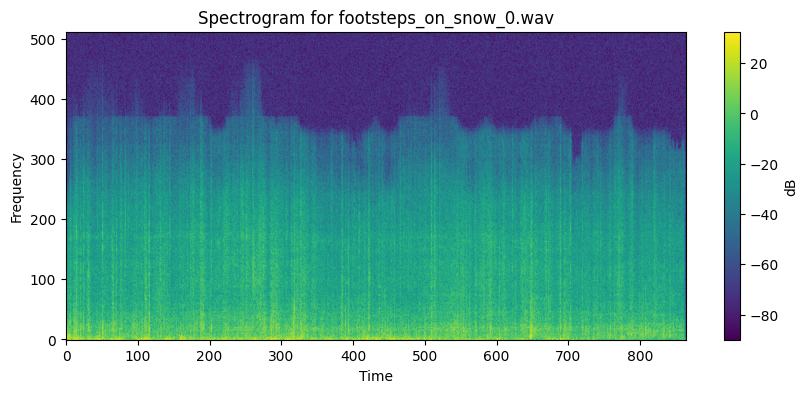

Audio playback for footsteps_on_snow_0.wav:


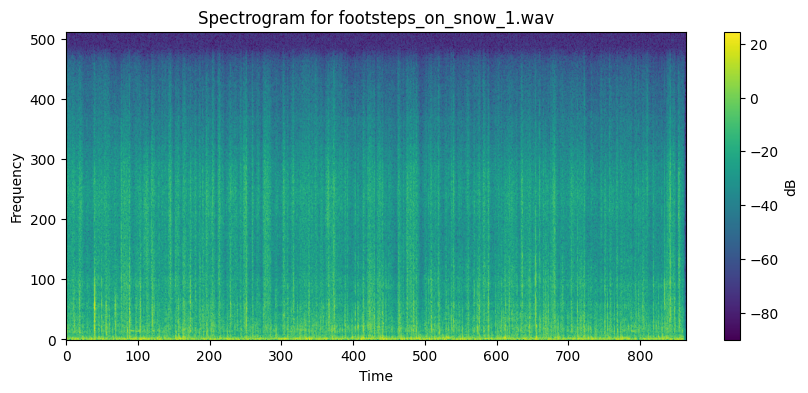

Audio playback for footsteps_on_snow_1.wav:


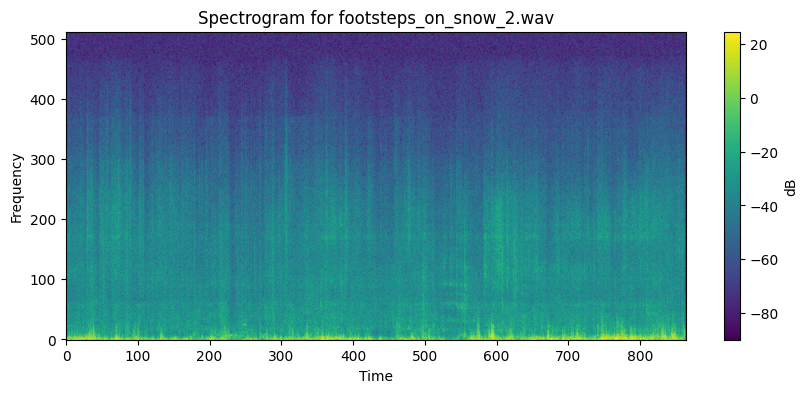

Audio playback for footsteps_on_snow_2.wav:


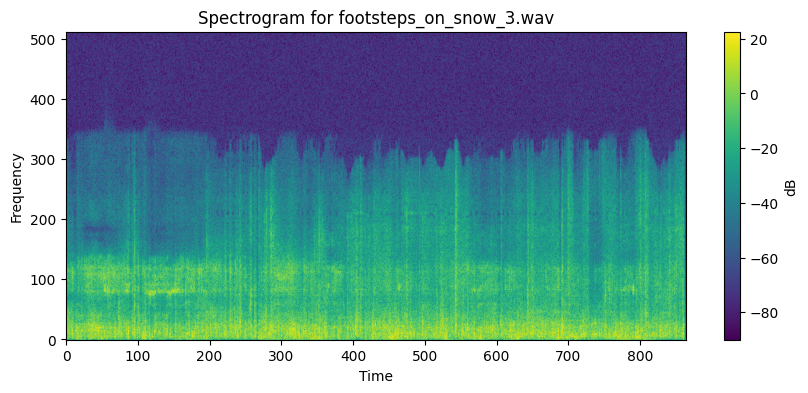

Audio playback for footsteps_on_snow_3.wav:


In [11]:
wav_files = sorted(glob.glob(os.path.join(outdir, output_subdir, "*.wav")))
print("WAV files found in the output directory:")
for wf in wav_files:
    print("  ", wf)

# --- Display spectrograms and play audio for each WAV file ---
# Spectrogram transformation (adjust n_fft as needed)
spec_transform = torchaudio.transforms.Spectrogram(n_fft=1024)

for wav_file in wav_files:
    # Load the WAV file
    waveform, sample_rate = torchaudio.load(wav_file)
    
    # Compute the spectrogram and apply log transformation
    spec = spec_transform(waveform)
    spec_db = 10 * np.log10(spec.squeeze().numpy() + 1e-9)  # Add a small value to avoid division by zero
    
    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(spec_db, origin="lower", aspect="auto", cmap="viridis")
    plt.title(f"Spectrogram for {os.path.basename(wav_file)}")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(label="dB")
    plt.show()
    
    # Display the audio playback widget
    print(f"Audio playback for {os.path.basename(wav_file)}:")
    display(Audio(wav_file))